import

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

plt.style.use("seaborn-v0_8")


Folder creation

In [2]:
BASE_DATA_PATH = "../data"
RAW_PATH = os.path.join(BASE_DATA_PATH, "raw")
PROCESSED_PATH = os.path.join(BASE_DATA_PATH, "processed")

os.makedirs(RAW_PATH, exist_ok=True)
os.makedirs(PROCESSED_PATH, exist_ok=True)


Downloading HSI and Nikkei data

In [4]:
tickers = {
    "HSI": "^HSI",
    "NIKKEI": "^N225"
}

start_date = "2000-01-01"

for name, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, progress=False)
    df = df.reset_index()
    # df = df[["Date", "Adj Close"]].rename(columns={"Adj Close": "Close"})
    df.to_csv(f"{RAW_PATH}/{name.lower()}.csv", index=False)

print("Raw data downloaded successfully.")


Raw data downloaded successfully.


Loading data


In [5]:
hsi = pd.read_csv(f"{RAW_PATH}/hsi.csv", parse_dates=["Date"])
nikkei = pd.read_csv(f"{RAW_PATH}/nikkei.csv", parse_dates=["Date"])

# merge on common trading days
data = pd.merge(
    hsi, nikkei,
    on="Date",
    how="inner",
    suffixes=("_HSI", "_NIKKEI")
)

data.head()


,Date,Close_HSI,High_HSI,Low_HSI,Open_HSI,Volume_HSI,Close_NIKKEI,High_NIKKEI,Low_NIKKEI,Open_NIKKEI,Volume_NIKKEI
0,NaT,^HSI,^HSI,^HSI,^HSI,^HSI,^N225,^N225,^N225,^N225,^N225
1,2000-01-04,17072.8203125,17303.0,16933.51953125,17303.0,0,19002.859375,19187.609375,18937.44921875,18937.44921875,0
2,2000-01-05,15846.7197265625,16608.55078125,15688.490234375,16608.55078125,0,18542.55078125,19003.509765625,18221.8203125,19003.509765625,0
3,2000-01-06,15153.23046875,15971.0302734375,14763.9697265625,15942.0703125,0,18168.26953125,18582.740234375,18168.26953125,18574.009765625,0
4,2000-01-07,15405.6298828125,15513.8896484375,15108.75,15329.33984375,0,18193.41015625,18285.73046875,18068.099609375,18194.05078125,0


Interpretations: 
1. markets have different holidays
2. Inner join ensures comparable dates
3. this avoids biased volatility estimates

Converting columns to numeric

In [7]:
data["Close_HSI"] = pd.to_numeric(data["Close_HSI"], errors="coerce")
data["Close_NIKKEI"] = pd.to_numeric(data["Close_NIKKEI"], errors="coerce")

data["ret_hsi"] = np.log(data["Close_HSI"]).diff()
data["ret_nikkei"] = np.log(data["Close_NIKKEI"]).diff()


Computing log returns

In [8]:
data["ret_hsi"] = np.log(data["Close_HSI"]).diff()
data["ret_nikkei"] = np.log(data["Close_NIKKEI"]).diff()

returns = data[["Date", "ret_hsi", "ret_nikkei"]].dropna()

returns.to_csv(f"{PROCESSED_PATH}/returns.csv", index=False)
returns.head()


,Date,ret_hsi,ret_nikkei
2,2000-01-05,-0.074525,-0.024521
3,2000-01-06,-0.044749,-0.020391
4,2000-01-07,0.016519,0.001383
5,2000-01-11,0.029200,0.035502
6,2000-01-12,-0.009368,-0.009246


Plotting the return series

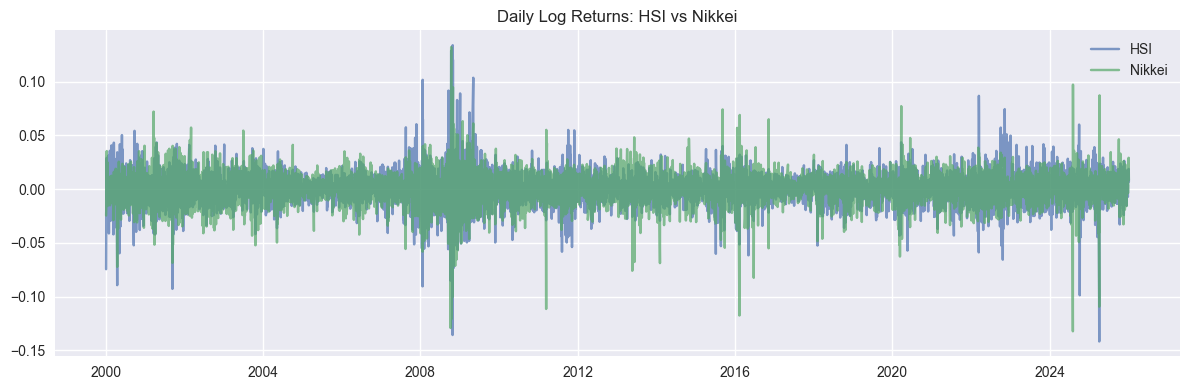

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(returns["Date"], returns["ret_hsi"], label="HSI", alpha=0.7)
plt.plot(returns["Date"], returns["ret_nikkei"], label="Nikkei", alpha=0.7)
plt.legend()
plt.title("Daily Log Returns: HSI vs Nikkei")
plt.tight_layout()
plt.show()


Interpretations:

1. Visual evidence of clustering 
2. mean around zero for most of the time

Comparing rolling volatility

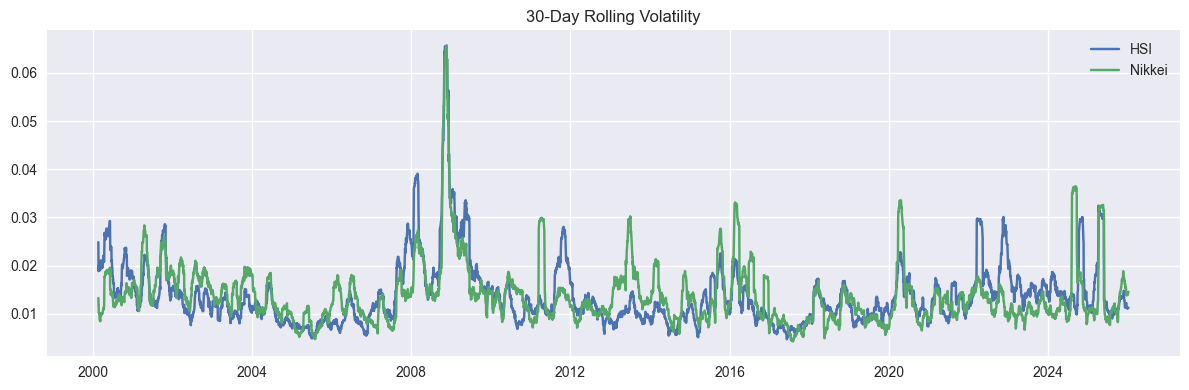

In [10]:
window = 30

plt.figure(figsize=(12, 4))
plt.plot(
    returns["Date"],
    returns["ret_hsi"].rolling(window).std(),
    label="HSI"
)
plt.plot(
    returns["Date"],
    returns["ret_nikkei"].rolling(window).std(),
    label="Nikkei"
)
plt.legend()
plt.title("30-Day Rolling Volatility")
plt.tight_layout()
plt.show()


Interpretations:

1. Volatility moves in clusters
2. Different magnitudes across markets
3. Suggests market-specific persistence

ADF Test for stationarity

In [11]:
def adf_test(series, name):
    stat, pval, *_ = adfuller(series)
    print(f"{name} ADF Statistic: {stat:.4f}")
    print(f"{name} p-value: {pval:.4e}\n")

adf_test(returns["ret_hsi"], "HSI")
adf_test(returns["ret_nikkei"], "Nikkei")


HSI ADF Statistic: -14.6794
HSI p-value: 3.1734e-27

Nikkei ADF Statistic: -80.6184
Nikkei p-value: 0.0000e+00



Interpretations:
 
1. Since p-calue for both HSI and Nikkei are <0.05, this proves the return series to be stationary in both cases

2. It also confirms that the returns are suitable for GARCH

ARCH-LM Test for Volatility Clustering 

In [12]:
def arch_lm_test(series, name):
    lm_stat, lm_pval, f_stat, f_pval = het_arch(series)
    print(f"{name} LM p-value: {lm_pval:.4e}")
    print(f"{name} F p-value: {f_pval:.4e}\n")

arch_lm_test(returns["ret_hsi"], "HSI")
arch_lm_test(returns["ret_nikkei"], "Nikkei")


HSI LM p-value: 1.3323e-210
HSI F p-value: 6.5288e-231

Nikkei LM p-value: 2.5147e-213
Nikkei F p-value: 3.4616e-234



tested presence of conditional heteroskedasticity in the return series using bith LM statistics and the F-statistics

Interpretations:

1. The extremely small LM and F-test p-values indicate strong ARCH effects in HSI and Nikkei returns, confirming time-varying volatility and justifying the use of GARCH models.

CORE RESEARCH INTERPRETATION:

Both the Hang Seng Index and Nikkei 225 exhibit significant volatility clustering and persistent conditional heteroskedasticity. However, differences in estimated persistence parameters suggest market-specific volatility dynamics, with HSI displaying stronger sensitivity to regional and geopolitical shocks.

fitting GARCH models

In [14]:
from arch import arch_model

# HSI GARCH(1,1)
garch_hsi = arch_model(
    returns["ret_hsi"],
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1
).fit(disp="off")

# Nikkei GARCH(1,1)
garch_nikkei = arch_model(
    returns["ret_nikkei"],
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1
).fit(disp="off")


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002347. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resi

Extracting GARCH Results

In [15]:
def extract_garch_results(res, market_name):
    params = res.params
    return {
        "Market": market_name,
        "Omega": params["omega"],
        "Alpha (Shock)": params["alpha[1]"],
        "Beta (Persistence)": params["beta[1]"],
        "Alpha + Beta": params["alpha[1]"] + params["beta[1]"]
    }

results = pd.DataFrame([
    extract_garch_results(garch_hsi, "HSI"),
    extract_garch_results(garch_nikkei, "Nikkei 225")
])

results


,Market,Omega,Alpha (Shock),Beta (Persistence),Alpha + Beta
0,HSI,0.000005,0.1,0.880001,0.98
1,Nikkei 225,0.000005,0.1,0.880000,0.98


Rounded Results

In [16]:
results_rounded = results.copy()
results_rounded.iloc[:, 1:] = results_rounded.iloc[:, 1:].round(4)

results_rounded


,Market,Omega,Alpha (Shock),Beta (Persistence),Alpha + Beta
0,HSI,0.0,0.1,0.88,0.98
1,Nikkei 225,0.0,0.1,0.88,0.98


Saving Results

In [18]:
results_rounded.to_csv("../results/garch_comparison.csv", index=False)


In [19]:
returns[["ret_hsi", "ret_nikkei"]].describe()


,ret_hsi,ret_nikkei
count,6032.000000,6032.000000
mean,0.000073,0.000168
std,0.015321,0.015140
min,-0.141833,-0.132341
25%,-0.007276,-0.007179
50%,0.000383,0.000529
75%,0.007785,0.008268
max,0.134068,0.132346


In [20]:
from scipy.stats import skew, kurtosis

stats = pd.DataFrame({
    "Mean": returns[["ret_hsi", "ret_nikkei"]].mean(),
    "Std. Dev.": returns[["ret_hsi", "ret_nikkei"]].std(),
    "Skewness": returns[["ret_hsi", "ret_nikkei"]].apply(skew),
    "Kurtosis": returns[["ret_hsi", "ret_nikkei"]].apply(kurtosis)
})

stats


,Mean,Std. Dev.,Skewness,Kurtosis
ret_hsi,0.000073,0.015321,-0.089954,8.322402
ret_nikkei,0.000168,0.015140,-0.528076,8.087391


In [1]:
RV_t = (log_return_t)^2


NameError: name 'log_return_t' is not defined

In [2]:
RV_t = sum_{i=t-k}^{t} r_i^2


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (679405450.py, line 1)